In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 2. Single particle tracking



## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

import datasets

import scipy.io as IO

IMAGE_SIZE = 64

## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 48 by 48 pixel images, containing a single particle each. The particles are simulated as spheres with a radius between 0.5 microns and 1 micron, and a refractive index between 1.4 and 1.6. Its position in the camera plane is constrained to be within the image, and is sampled with a normal distribution with standard deviation of 5 pixel units in along the axis normal to the camera plane. 

In [3]:
particle = dt.MieParticle(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 2 - 1,
    z=lambda: np.random.randn() * 2,
    radius=lambda:1e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.rand() * 0.3 + 1.37,
    L=8,
    position_unit="pixel",
)

The particle is imaged using a brightfield microscope with NA between 0.6 and 0.9, illuminating laser wavelength between 400 and 700 nm, a magnification between 4 and 10, and a random illumination gradient.

In [4]:
# SA = dt.SphericalAberration(coefficient=lambda: np.random.randn() * 0.2)
HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=23)

optics = dt.Brightfield(
    NA=1.1,
    resolution=1.13e-6,
    wavelength=635e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil= HC + VC + CROP
)

The noise is simulated as poisson noise with an signal to noise ratio between 10 and 50. The image is finally normalized by rescaling it to values between 0 and 1.

In [5]:
real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda level: level * 0.03, 
    level=lambda: np.random.rand() * 0.8
)

noise = real_noise + dt.Gaussian(mu=0, sigma=lambda: real_noise.level * 0.03j)

def func(real_fac=1/0.61, imag_fac=1/0.61):
    def inner(image):
        image = -(image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func, real_fac=1/0.61, imag_fac=1/0.61)

We now define how these objects combine. Calling the optics object with the particle object tells DeepTrack to that is should image that particle using that optical device. We define an augmented version of `imaged_particle` which will increase the speed of the training. To bypass this augmentation during validation we create a conditional feature, which calls `imaged_particle` directly if `skip_augmentation=True`.

Finally we add in the noise and the normalization.

In [6]:

image_of_particle = optics(particle + noise)  + complex_to_float

dataset = image_of_particle 

### 2.2 Defining the training label

The training label is extracted directly from the image as the `position` property divided by the image size, such that the posible values are contained within 0 and 1.

In [7]:
def get_label(image):
    px = np.array(image.get_property("position")) - IMAGE_SIZE / 2
    z = image.get_property("z") * 0.1
    r = image.get_property("radius") / 1e-6
    n = image.get_property("refractive_index") - 1.33
    return np.array([*px, z, r * 10, n * 10])

# 2.3 Visualizing the dataset

We resolve and show 16 images, with a green circle indicating the particle position.

In [8]:
Data = IO.loadmat(r'D:\databatches\191003Every0_19\res\DataDT_0.mat')
validation = Data["batch"][0]
# positions = Data["positions"][0]
print(len(validation))
# reduced_validation, red_pos = zip(*[(im,pos) for im, pos in zip(validation, positions) if np.max(np.abs(im[:, :, 1])) > 0.1])

70


## 3. Defining the network

The network used is a Convolutional network, with a the pixel error as loss.

In [9]:
import keras.backend as K
import keras.optimizers as optimizers

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    conv_layers_dimensions=(32, 64, 128),
    dense_layers_dimensions=(64, 64),
    steps_per_pooling=2,
    number_of_outputs=5,
    dropout=(.2, .2, .2),
    loss="mae",
    optimizer="adam"
)


## 4. Training the network

There are two main ways to provide the model with training data. If the data is too large to be contained in memory, we provide a generator in `deeptrack.Generators` to continuously generate new training data. Here, the images are small enough to be contained in memory, which is why we instead create the full training set in advance. This is significantly faster than generating on the fly, since tensorflow is allowed to optimize the data transfer.

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

validation_set_size = 256

# #Update forces min_snr=5
# validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
# validation_labels = [get_label(image) for image in validation_set]

# generator = dt.generators.ContinuousGenerator(
#     dataset,
#     get_label,
#     min_data_size=int(4e3),
#     max_data_size=int(2e4),
#     batch_size=64
# )

# generator.min_data_size=1
# minerr = 0.038
with generator:
    while True:
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            epochs=1,
            verbose=0
        )
        predictions = np.array([
            np.mean(
                model.predict(
                    np.array(validation[idx])
                ),
                axis=0
            ) for idx in indexes
        ])
        err = np.mean(predictions[:, 4] / 10) + 1.33 - 1.58
        print(err)
        if np.abs(err) < minerr:
            minerr = np.abs(err)
            model.save_weights("temp.h5")
            
#         indexes = []
#         for i, p in enumerate(predictions):
#             if p[3] / 10 < 0.19:
#                 indexes.append(i)

-0.056768596172332764
-0.05933253467082977
-0.060825660824775696
-0.06162466108798981
-0.05133374035358429
-0.05582910776138306
-0.05385856330394745
-0.05942998826503754
-0.06491829454898834
-0.05774064362049103
-0.03889487683773041
-0.07099248468875885
-0.0567142516374588
-0.07294026017189026
-0.08209621906280518
-0.059869974851608276
-0.05839890241622925
-0.06627215445041656
-0.06752826273441315
-0.06105215847492218
-0.06102059781551361
-0.06856521964073181
-0.05797816812992096
-0.059194087982177734
-0.0590115487575531
-0.06265273690223694
-0.05583059787750244
-0.06581306457519531
-0.06385192275047302
-0.05717949569225311
-0.05701722204685211
-0.07042703032493591
<class 'KeyboardInterrupt'>  <traceback object at 0x000001FB9A65FEC8>


In [34]:
# model.save_weights("temp.h5")

## 5. Evaluating the network

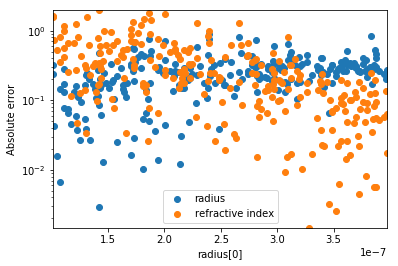

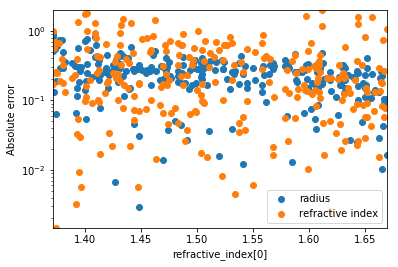

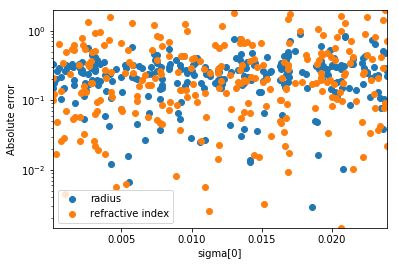

In [71]:
properties = ["radius", "refractive_index", "sigma"]

validation_prediction = model.predict(np.array(validation_set))

validation_errors = [
    np.abs(validation_prediction[:, idx] - np.array(validation_labels)[:, idx]) for idx in range(3, 5)
]

error_names = ["radius", "refractive index"]

for property_name in properties:
    property_values = np.array([image.get_property(property_name) for image in validation_set])
    if property_values.ndim == 1:
        property_values = np.expand_dims(property_values, axis=-1)
    
    for col in range(property_values.shape[1]):
        values = property_values[:, col]

        plt.subplot(1, property_values.shape[1], col + 1)
        for validation_error in validation_errors:
            plt.scatter(values, validation_error, alpha=1)
        plt.xlim([np.min(values), np.max(values)])
        plt.ylim([np.min(validation_error), np.max(validation_error)])
        plt.yscale("log")
        plt.ylabel("Absolute error")
        plt.xlabel("{0}[{1}]".format(property_name, col))
        
    plt.legend(error_names)

    
    plt.show()

In [ ]:
model.load_weights("./models/ParticleSizing.h5")

In [61]:
## NUMBER_OF_IMAGES = 16

for i in range(1):
    dataset.update(c1=0, c2=0, radius=0.24e-6, refractive_index=1.58, z=0, position=(31, 32), level=0, polarization_angle=0)
    image_of_particle = dataset.resolve()

    
    position_of_particle = get_label(image_of_particle) + IMAGE_SIZE / 2
#     plt.subplot(1,2,1)
#     plt.imshow(image_of_particle[:, :, 0], cmap="gray")
#     plt.colorbar()
    
#     plt.subplot(1,2,2)
#     plt.imshow(validation[i][0, :, :, 1], cmap="gray")
#     plt.colorbar()
#     plt.show()
    
#     plt.plot(image_of_particle[32, :, 0], 'r')
#     plt.plot(validation[i][0, :, 32, 0])
#     plt.show()
    
#     plt.plot(image_of_particle[:, 32, 1], 'r')
#     plt.plot(validation[i][0, :, 32, 1])
#     plt.show()
    
IO.savemat(r'C:\Users\bmidt\Holography tracking\NNetwork\field.mat', {'field': image_of_particle})

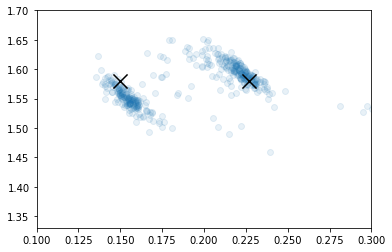

In [70]:
# batch = IO.loadmat("457nmPSL.mat")["batch"]

model.load_weights("temp.h5")
Data = IO.loadmat(r'D:\databatches\191003Every0_19\res\DataDT_0.mat')
validation = Data["batch"][0]
predictions = np.array([
        np.mean(
            model.predict(
                np.array(validation[idx])
            ),
            axis=0
        ) for idx in range(0, len(validation), 1)
])

# indexes = []
# for i, p in enumerate(predictions):
#     if p[3] / 10 < 0.19:
#         indexes.append(i)
plt.scatter( predictions[:, 3] / 10,   predictions[:, 4] / 10 + 1.33, alpha=0.1)
plt.scatter(0.227, 1.58, marker='x', s=200, c='k')
plt.scatter(0.15, 1.58, marker='x', s=200, c='k')
plt.axis([0.1, 0.3, 1.33, 1.7])
plt.show()

In [ ]:
import random
random.shuffle(sim_ims)
IO.savemat('sizing', {"batch": sim_ims})